<a href="https://colab.research.google.com/github/igordantasgf/analise_dados_microambientais/blob/main/fly_eye_visualize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [298]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp2d
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import clear_output
import plotly.express as px
import plotly.graph_objects as go

In [3]:
col = ['TIMESTAMP', '"RECORD"', '"rtime"', '"batt_volt"', '"panel_temp"', '"CM3Up_mv_Avg"', '"CM3Up_Wm2_Avg"', '"CMP21_Avg"', '"CMP21_Wm2_Avg"', '"CelSol_01_Avg"', '"CelSol_02_Avg"', '"CelSol_03_Avg"', '"CelSol_04_Avg"', '"CelSol_05_Avg"', '"CelSol_06_Avg"', '"CelSol_07_Avg"', '"CelSol_08_Avg"', '"CelSol_09_Avg"', '"CelSol_10_Avg"', '"CelSol_11_Avg"', '"CelSol_12_Avg"', '"CelSol_13_Avg"', '"CelSol_14_Avg"', '"CelSol_15_Avg"', '"CelSol_16_Avg"', '"CelSol_17_Avg"']
labmim = pd.read_csv('/content/drive/MyDrive/Bolsa - Edson/plataforma/LBM_solar_2022.dat',sep=';', header=None,skiprows=lambda x:x in [0,1,2,3], names=col)
labmim[col] = labmim.TIMESTAMP.str.split(",", expand = True)
labmim.index = (labmim['TIMESTAMP'])
clear_output()

In [4]:
def calcular_nan():
  count = labmim.isna().any(axis=1).sum()
  print(f"Number of rows with at least one NaN value: {count}")
  print(f"Total rows in series: {len(labmim)}")
calcular_nan()

Number of rows with at least one NaN value: 0
Total rows in series: 459301


In [5]:
#@markdown ## Organização da tabela de dados
sensors=col[9:]
labmim_backup = labmim

for i in sensors:
  x=0
  unique_types = set()
  #for item in labmim_backup[i]:
  #  unique_types.add(type(item))
  #print(unique_types)
  labmim_backup[i] = [int(x) if str(x).isdigit() else 0 for x in labmim_backup[i]]

# Coluna com separação de horas para agrupamento e agregação
labmim_backup['data_hora'] = [i[0:13] for i in labmim_backup['TIMESTAMP']]

In [181]:
#@markdown # Função para separar valores (soma, média d.m., média h.m, etc)
sensors=col[9:]

#@markdown #### </p> **gerar_valores(tabela, var)**
def gerar_valores(tabela,var):
  values=[]
  if var==0: #@markdown - 0 = Soma de todos os valores da série
    for i in sensors:
      values.append(sum(labmim_backup[i]))
    final = [values[0:8],values[8:16],[values[16]]*8]
    return final

#@markdown #### </p> **gerar_ranged(tabela, date1, date2)**
#@markdown ##### Dados separados em: média(acumulado(média/hora)/dia)
#@markdown - tabela = base de dados original (normalmente, "labmim_backup")
#@markdown - date1 = Data incial a ser analisada $($formato: "$2012-04-12$"$)$
#@markdown - date2 = Data final a ser analisada. Se não for informado, analisa até o último dia registrado.
def gerar_ranged(tabela, date1, date2=None):
  values=[]

  if date2 != None:
    range1, range2 = date1+" 00:00:00", date2+" 00:00:00"
    tabela = labmim_backup.loc[range1:range2]
  else:
    range1 = date1+" 00:00:00"
    tabela = labmim_backup.loc[range1:]


  tabela = tabela.groupby('data_hora').agg('mean') # média por hora

  tabela['datas'] = [i[0:10] for i in tabela.index]
  tabela = tabela.groupby('datas').agg('sum') # acumulado por dia

  tabela = tabela.agg('mean') # média do range de dias
  final = [tabela[0:8],tabela[8:16],[tabela[16]]*8]
  return final

#@markdown #### </p> **gerar_horarios_dia(tabela, date1, date2)**
#@markdown ##### Retorna dados separados em 8 dataframes para os horário:
#@markdown
#@markdown  | 06:00 | 09:00 | 12:00 | 15:00 | 18:00 |
#@markdown  |-------|-------|-------|-------|-------|
#@markdown
#@markdown com a média de valores para a faixa de tempo determinada
#@markdown - tabela = base de dados original (normalmente, "labmim_backup")
#@markdown - date1 = Data incial a ser analisada $($formato: "$2012-04-12$"$)$
#@markdown - date2 = Data final a ser analisada. Se não for informado, analisa até o último dia registrado.
def gerar_horarios_dia(tabela, date1, date2=None):
  if date2 != None:
    range1, range2 = date1+" 00:00:00", date2+" 00:00:00"
    tabela = labmim_backup.loc[range1:range2]
  else:
    range1 = date1+" 00:00:00"
    tabela = labmim_backup.loc[range1:]

  tabela = tabela.groupby('data_hora').agg('mean')

  tabela['horas'] = [i[11:] for i in tabela.index]
  tabela = tabela.groupby('horas').agg('mean')

  valores = []
  for i in ['06','09','12','15','18']:
    tabela_i = tabela.loc[i]
    valores.append(pd.concat([pd.Series([tabela_i[16]]*8, ["CelSol_17_1Avg","CelSol_17_2Avg","CelSol_17_3Avg","CelSol_17_4Avg","CelSol_17_5Avg","CelSol_17_6Avg","CelSol_17_7Avg","CelSol_17_8Avg"]),tabela_i[8:16],tabela_i[0:8]]))

  return valores

In [68]:
#@markdown ## Formação das novas coordenadas para a interpolação
#@markdown - Matriz 6x100 replicada à esquerda e direita, resultando em uma matriz 6x300
#@markdown - Ao fim, será extraído uma matriz a partir do meio, com dimensões 6x100
pol = []
colunas_i=[round(i) for i in np.linspace(10,590,48)]
for u in [5,3,1]:
  p = []
  for v in colunas_i:
    p.append([u,v])
  pol.append(p)

In [69]:
#@markdown ## Função de interpolação
#@markdown #### **metodo**:
#@markdown - "geral" : valor acumulado para todos os sensores
#@markdown - "tempo" : valor acumulado para todos os sensores
#@markdown - - inicio: ano-mes-dia
#@markdown - - fim: ano-mes-dia. Se não for informado, calcula até a última linha

#matriz_original = gerar_valores(labmim_backup, 0)
def interpolar_dados(metodo, inicio=None, fim=None):
  if metodo == 'tempo':
    matriz_original = gerar_ranged(labmim_backup, inicio, fim) # <---   Colocar range de datas aqui
  if metodo == 'geral':
    matriz_original = gerar_valores(labmim_backup, 0)

  matriz_original = np.hstack((matriz_original,matriz_original,matriz_original,matriz_original,matriz_original,matriz_original))
  coordenadas = np.array(pol)

  # Definindo a grade da nova matriz
  x_new = np.linspace(0, 599, 600)
  y_new = np.linspace(0, 5, 6)
  print(len(x_new))
  print(len(y_new))

  # Criando uma função interpoladora
  f = interp2d(coordenadas[:, :, 1], coordenadas[:, :, 0], matriz_original, kind='cubic')

  # Aplicando a função interpoladora na nova grade
  nova_matriz_expandida = f(x_new, y_new)
  clear_output()
  return nova_matriz_expandida

<ipython-input-70-0106c1cfd796>:8: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



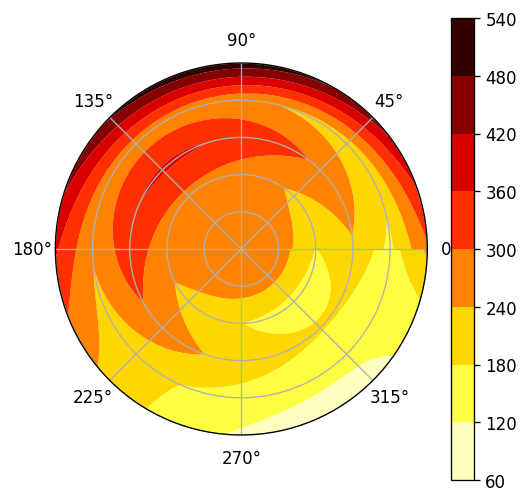

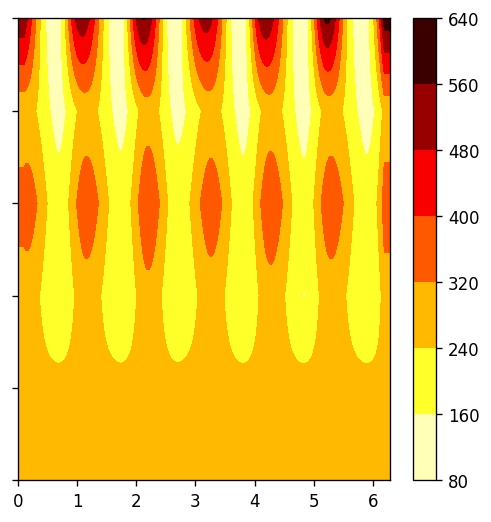

In [70]:
nova_matriz_expandida = interpolar_dados('tempo', '2022-04-01', '2022-06-01')
nova_matriz = nova_matriz_expandida[:,275:375]

a = np.linspace(0,2*np.pi,100) # Sepação das partes em radianos
b = np.linspace(0,1,6) # Camadas por distancia ao centro
c = nova_matriz

orig_map=plt.cm.get_cmap('hot')

#actual plotting
fig, ax = plt.subplots(figsize=(5,5),dpi=120,subplot_kw=dict(projection='polar'))
ax.set_yticklabels([])
ctf = ax.contourf(a, b, c, cmap=orig_map.reversed(), antialiased=True)
plt.colorbar(ctf)

fig, ax1 = plt.subplots(figsize=(5,5),dpi=120)
ax1.set_yticklabels([])
ctf = ax1.contourf(np.linspace(0,2*np.pi,600), b, nova_matriz_expandida, cmap=orig_map.reversed())
plt.colorbar(ctf)

<ipython-input-181-ab0e6f3710f5>:56: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



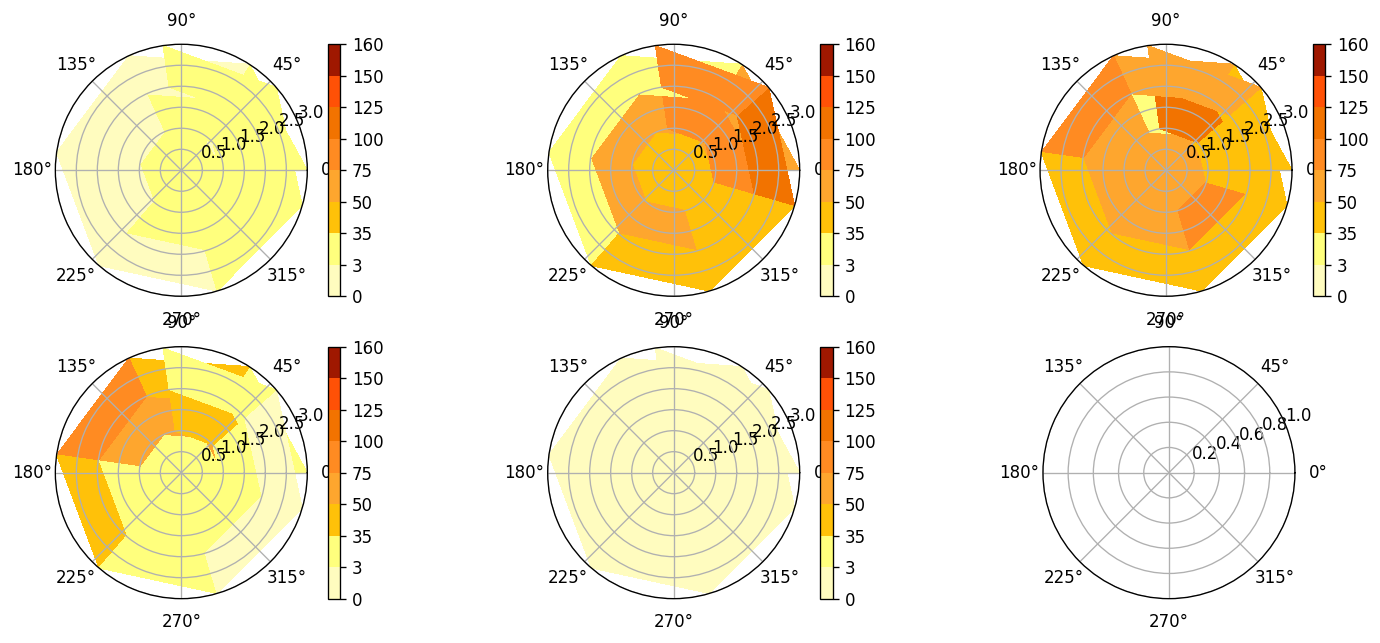

In [297]:
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
import plotly.express as px

dados_horarios = gerar_horarios_dia(labmim_backup, '2022-09-04', '2022-09-05')
fig, axs = plt.subplots(2,3,figsize=(15,6),dpi=120, subplot_kw=dict(projection='polar'))
#orig_map=plt.cm.get_cmap('hot')
bounds = [0,3,35,50,75,100,125,150,160]
colors = ['#fffcbf','#ffff7d','#ffc109','#fea62e','#ff8b22','#f27300','#ff5106','#dd2d00','#9f1800']
cmap = matplotlib.colors.ListedColormap(colors)
norm = matplotlib.colors.BoundaryNorm(bounds, len(colors))


a = np.linspace(0,2*np.pi,8) # Sepação das partes em radianos
b = np.linspace(0,1,3) # Camadas por distancia ao centro

for ax,x in zip(axs.flat,dados_horarios):
  ctf = ax.pcolor([x[0:8], x[8:16], x[16:24]], cmap=cmap, norm=norm)
  plt.colorbar(ctf)


plt.show()

In [300]:
directions = pd.Series(['N','NW', 'W', 'SW', 'S', 'SE', 'E', 'NE','N','NW', 'W', 'SW', 'S', 'SE', 'E', 'NE','N','NW', 'W', 'SW', 'S', 'SE', 'E', 'NE'], dados_horarios[0].index, name='directions')
angle = pd.Series([1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3], dados_horarios[0].index, name='angle')
DataFramesList = []
for i in dados_horarios:
  i.name = 'valores'
  DataFramesList.append(pd.DataFrame(pd.concat([i,directions,angle], axis=1, sort=False)))
horarios = ['06:00', '09:00', '12:00', '15:00', '18:00']

# Define initial DataFrame index
current_df_index = 2

# Create the initial plot
fig = go.Figure(data=[
    go.Barpolar(
        r=DataFramesList[current_df_index]['angle'],
        theta=DataFramesList[current_df_index]['directions'],
        marker_color=DataFramesList[current_df_index]['valores'],
        thetaunit='radians',
        hovertemplate='Angle: %{r}<br>Direction: %{theta}<br>Value: %{marker.color}'
    )
])

# Configure the layout
fig.update_layout(
    polar=dict(radialaxis=dict(visible=True)),
    coloraxis=dict(colorscale='YlOrRd', colorbar=dict(y=0.85, len=0.75)),
    showlegend=False,
    title=f"DataFrame {current_df_index}"
)

# Define the callback function for the button click
def update_plot(button_click):
    # Get the DataFrame index from the clicked button
    button_index = button_click['args'][1]['args2']['indice']

    # Update the current DataFrame index
    global current_df_index
    current_df_index = button_index

    # Update the plot with the selected DataFrame
    fig.data[0].r = [DataFramesList[current_df_index]['angle']]
    fig.data[0].theta = [DataFramesList[current_df_index]['directions']]
    fig.data[0].marker.color = [DataFramesList[current_df_index]['valores']]

    # Update the hovertemplate
    fig.data[0].hovertemplate = 'Angle: %{r}<br>Direction: %{theta}<br>Value: %{marker.color}'

    # Update the color scale
    fig.update_traces(marker_coloraxis='coloraxis')

    # Update the layout title
    fig.update_layout(title=f"DataFrame {current_df_index}")

    # Update the layout
    fig.update_layout(polar=dict(radialaxis=dict(visible=True)))

# Create the buttons
buttons = []
for i in range(len(DataFramesList)):
    button = dict(
        label=f'DataFrame {i}',
        method='update',
        args=[
            {'r': [DataFramesList[i]['angle']], 'theta': [DataFramesList[i]['directions']], 'marker.color': [DataFramesList[i]['valores']]},
            {'args2': {'indice': i}}
        ]
    )
    buttons.append(button)

# Add the buttons to the layout
fig.update_layout(
    updatemenus=[
        dict(
            type='buttons',
            buttons=buttons,
            direction='down',
            pad={'r': 10, 't': 10},
            showactive=True,
            x=0.1,
            xanchor='left',
            y=1.15,
            yanchor='top'
        )
    ]
)

# Assign the update_plot function as the button click handler
fig.data[0].on_click(update_plot)

# Display the figure
fig.show()
